In [1]:
# Environment Variables
from dotenv import load_dotenv
load_dotenv(".env");

# System Modules
from pathlib import Path

# General Purpose Libraries 
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

# Paths, Datasets and Datamodules
from etl.pathfactory import PathFactory
from etl.etl import reset_dir
from data.datamodules import ImageDatasetDataModule 
from datasets.imagenette import ImagenetteClassification

# Transforms
import torchvision.transforms.v2 as t

# Models
from torchvision.models import alexnet, AlexNet_Weights

# Tasks
from training.tasks import ClassificationTask

# Loggers
import wandb
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger, CSVLogger

#Trainers
from lightning import Trainer

# Type Hints
from typing import Callable, Any, Optional, Literal
from numpy.typing import NDArray

In [3]:
LOGS_DIR = Path.cwd() / "logs"
CHECKPOINTS_DIR = LOGS_DIR / "checkpoints"

In [4]:
def setup_checkpoint(
        checkpoint_dir: Path,
        monitor_metric: str,
        mode: Literal["min", "max"],
) -> ModelCheckpoint:

    return ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename="{epoch}-{" + f"{monitor_metric}" + ":2d}",
        monitor=monitor_metric,
        mode=mode,
        save_top_k=1,
        save_last=True,
        save_on_train_epoch_end=True,
    )

csv_logger = CSVLogger(
    save_dir=LOGS_DIR,
    name="csv",
    version=1,
)

#wandb.finish()
wandb_logger = WandbLogger(
    save_dir=LOGS_DIR,
    project="imagenette",
    log_model=False,
    name="alexnet-logging-test",
    version='1',
    offline=True,
)

In [ ]:
# TODO Priority Features
# Write Datasets for EuroSAT, Resisc, Urban Footprint
# Write Datasets for So2Sat-LCZ, So2Sat-Pop, Sen12Floods, BigEarthNet-MM, PASTIS-R
# Write Dataset using TorchGeo for Hypercrop (understand how it geo-samples and reprojects at runtime)


# TODO Important Features

# IMPORTANT: CLEANUP THE RUNTIME ELEMENTS 
#            Supress lightning debugging info (add a verbose: bool option?), 
#            Only have one progress bar at a time and remove it when done 

# Classification Report: Confusion Matrix -> Classwise + Macro + Micro Metrics
# For Classification Tasks: Log filenames + labels which were incorrectly classified from the validation dataset
# For Segmentation Tasks: Log filenames + iou + dice which were below a threshold from the validation dataset
# Visualize training loss and validation loss during training using matplotlib animations 

# Learninng Rate Scheduler (after some experience with training large models)

# TODO QoL Features 
# Experiment Config using Pydantic to Validate Parameters  
# Added Status Messages to DataModule to reflect experimental setup (peace of mind)

# Rewrite Optimizer Factory: Training Params -> Optimizer Object 
# Rewrite Loss Factory (Dict? Named Tuple? Enum?): Loss[str] -> Loss[nn.Module]

# Make Checkpointing and Logging more elegant -> Think / Read Other Solutions
# Checkpoint Name: {dataset-name}-{model-name}-{metric_1}.ckpt
# Display Checkpoint: .ckpt file -> Visualize Model, Experimental Config, Training History, etc
# Display Metrics: .csv log file -> Visualize Training Metrics (Value vs Epoch), Confusion Matrix (wandb style), etc.
# Figure out how to log negative samples (misclassified samples): Modified CSV Logger perhaps?

# TODO QoL Artifacts:

# To evaluate a .ckpt (1 epoch) on a eval dataset
# 1. Confusion Matrix: Classification Report
# 2. Negative Samples DataFrame: Grid Picture(a few samples / all samples) + Metric(s) + Attribution Map
# 3. Training History: Visualize Loss + Metrics vs Epoch / Step (read torchmetrics plotting)

# During training
# Animated Train Loss (+ Val Loss) vs Epoch / Step 
# Animated Monitor Validation Metric vs Epoch / Step

In [ ]:
# TODO Experimental Parameters (as general as possible):
# Parameters
# __________
# dataset_name: name of the dataset, used to name the root directory 
# task: Literal["classification", "segmentation"], used to name bucket on the cloud
# random_seed: for deterministic experments, mandatory


In [6]:
experiment = {
    "dataset_name": "imagenette",
    "task": "classification",

    "eval_split": 0.2,
    "batch_size": 32,
    "grad_accum": 1,
    "num_workers": 4,

    "num_classes": 10,
    "loss": "cross_entropy",
    "optimizer": "adam",
    "learning_rate": 1e-5,
    "momentum": 0,
    "weight_decay": 0,

    "checkpoint_metric": "val_macro_accuracy",
    "checkpoint_mode": "max"
}
model_ckpt = setup_checkpoint(
    CHECKPOINTS_DIR, 
    experiment["checkpoint_metric"],
    experiment["checkpoint_mode"]
)

paths = PathFactory(experiment["dataset_name"], experiment["task"])
dataset = ImagenetteClassification

image_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale=True),
    t.Normalize(dataset.MEANS, dataset.STD_DEVS),
    t.Resize((224, 224), antialias=True),
    t.RandomHorizontalFlip(0.5),
])

datamodule = ImageDatasetDataModule(
    root = paths.path,
    is_remote = False,
    is_streaming = False,
    dataset_constructor = dataset, 
    image_transform = image_transform,
    **experiment
)

alexnet_p = alexnet(weights=AlexNet_Weights.DEFAULT)
alexnet_p.classifier[-1] = torch.nn.Linear(4096, experiment.get("num_classes", 10))

In [10]:
trainer = Trainer(
    callbacks = [model_ckpt],
    logger = [csv_logger],
    #logger = [csv_logger, wandb_logger],

    #fast_dev_run = True,
    max_epochs=3,
    check_val_every_n_epoch=3,
    #limit_train_batches=30,
    #limit_val_batches=10,
    #limit_test_batches=10
)

last_ckpt_path = (CHECKPOINTS_DIR / "last.ckpt").as_posix() if (CHECKPOINTS_DIR / "last.ckpt").is_file() else None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Dataset Root Directory: /home/sambhav/datasets/imagenette
Dataset Root Directory: /home/sambhav/datasets/imagenette


/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/sambhav/dev/metacognition/geovision/logs/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/sambhav/dev/metacognition/geovision/logs/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                      | Params
--------------------------------------------------------------------
0 | model                 | AlexNet                   | 57.0 M
1 | criterion             | CrossEntropyLoss          | 0     
2 | val_metrics           | MetricCollection          | 0     
3 | val_cohen_kappa       | MulticlassCohenKappa      | 0     
4 | val_confusion_matrix  | MulticlassConfusionMatrix | 0     
5 | test_metrics          | MetricCollection          | 0     
6 | test_cohen_kappa      | MulticlassCohenKappa      | 0     
7 | test_confusion_matrix | MulticlassConfusionMa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


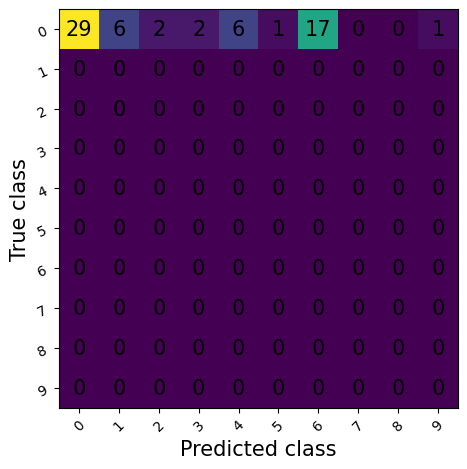

Training: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:369: `ModelCheckpoint(monitor='val_macro_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('val_macro_accuracy', value)` in the `LightningModule`?


Validation: |          | 0/? [00:00<?, ?it/s]

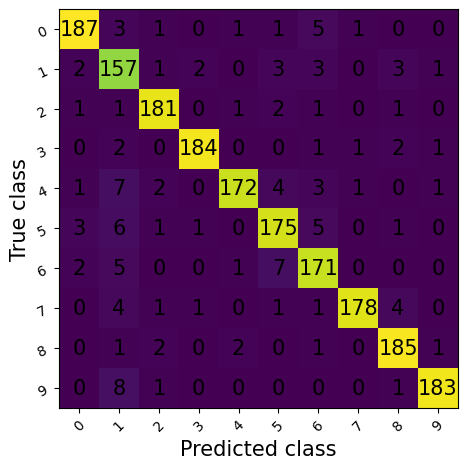

`Trainer.fit` stopped: `max_epochs=3` reached.


In [11]:
trainer.fit(
    model=ClassificationTask(alexnet_p, **experiment),
    datamodule=datamodule,
    ckpt_path=last_ckpt_path
)

Dataset Root Directory: /home/sambhav/datasets/imagenette


Restoring states from the checkpoint path at /home/sambhav/dev/metacognition/geovision/logs/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/sambhav/dev/metacognition/geovision/logs/checkpoints/last.ckpt
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

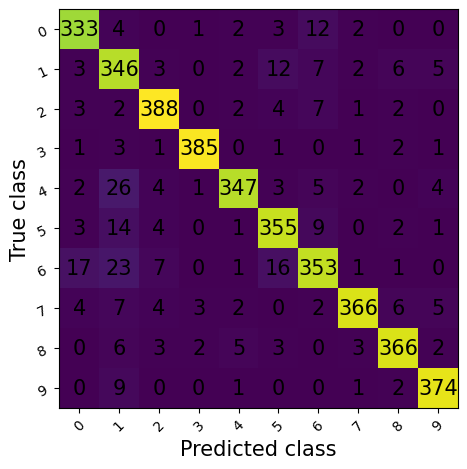

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_cohen_kappa      │    0.9116714000701904     │
│    test_macro_accuracy    │    0.9210436940193176     │
│     test_macro_auroc      │    0.9961519241333008     │
│       test_macro_f1       │    0.9210795760154724     │
│   test_macro_precision    │    0.9224857687950134     │
│     test_macro_recall     │    0.9210436940193176     │
│    test_micro_accuracy    │    0.9205095767974854     │
│   test_micro_precision    │    0.9205095767974854     │
│     test_micro_recall     │    0.9205095767974854     │
└───────────────────────────┴───────────────────────────┘

[{'test_macro_accuracy': 0.9210436940193176,
  'test_macro_auroc': 0.9961519241333008,
  'test_macro_f1': 0.9210795760154724,
  'test_macro_precision': 0.9224857687950134,
  'test_macro_recall': 0.9210436940193176,
  'test_micro_accuracy': 0.9205095767974854,
  'test_micro_precision': 0.9205095767974854,
  'test_micro_recall': 0.9205095767974854,
  'test_cohen_kappa': 0.9116714000701904}]

In [12]:
trainer.test(
    model=ClassificationTask(alexnet_p, **experiment),
    datamodule=datamodule,
    ckpt_path=last_ckpt_path
)

In [ ]:
wandb.finish()